In [1]:
def timing_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()  # Record start time
        result = func(*args, **kwargs)
        end_time = time.time()    # Record end time
        print(f"Function '{func.__name__}' executed in {end_time - start_time:.4f} seconds")
        return result
    return wrapper

In [2]:
def get_cloud_mask(flags):
    # Bits we want to reject
    reject_bits = 2
    # Boolean mask: True = keep pixel, False = reject
    cm = (flags & reject_bits) == 0

    # Choose the dilation structure (3×3 square here)
    structure = nd.generate_binary_structure(2, 1)
    cm_exp = ~nd.binary_dilation(~cm, structure=structure, iterations=2)
    
    return cm_exp

In [3]:
def get_land_mask(flags):
    # Bits we want to reject
    reject_bits = 1 
    # # Boolean mask: True = keep pixel, False = reject
    land_mask = (flags & reject_bits) == 0
    
    return land_mask

In [4]:
def get_bad_pixel_mask(flags):
    # Bits we want to reject
    reject_bits = 4 + 8 + 16 + 32 + 64 + 128 + 512 + 2048 + 4096
    # # Boolean mask: True = keep pixel, False = reject
    bad_pixel_mask = (flags & reject_bits) == 0

    # Choose the dilation structure (3×3 square here)
    structure = nd.generate_binary_structure(2, 1)
    bad_pixel_mask_exp = ~nd.binary_dilation(~bad_pixel_mask, structure=structure, iterations=2)
    
    return bad_pixel_mask_exp

In [5]:
import numpy as np
import xarray as xr
import rasterio
from rasterio.transform import from_origin
from pyproj import Transformer
from scipy.interpolate import griddata
from pathlib import Path
import time
import scipy.ndimage as nd
import matplotlib.pyplot as plt

# --- Open the NetCDF file ---
nc_path = Path("/home/data/ocean-colour/S2A_MSIL1C_20231114T092231_N0509_R093_T34SEE_20231114T112138_60m.nc")

In [53]:
ds = xr.open_dataset(nc_path)
ds
chla = ds["logchl"].values #isel(bands=0).values
lat = ds['latitude'].values
lon = ds['longitude'].values
flags = ds['bitmask'].astype("int32").values

### Cloud Mask

In [106]:
# Bits we want to reject
# reject_bits = 1 + 2 + 4 + 8 + 16 + 32 + 64 + 512 + 2048 + 4096
reject_bits = 2
# Boolean mask: True = keep pixel, False = reject
cm = (flags & reject_bits) == 0

# dist = nd.distance_transform_edt(cm)
# expand_radius = 5  # pixels
# cm_exp = ~(dist <= expand_radius)

# Choose the dilation structure (3×3 square here)
structure = nd.generate_binary_structure(2, 1)
cm_exp = ~nd.binary_dilation(~cm, structure=structure, iterations=8)

Text(0.5, 1.0, 'Cloud mask dilated')

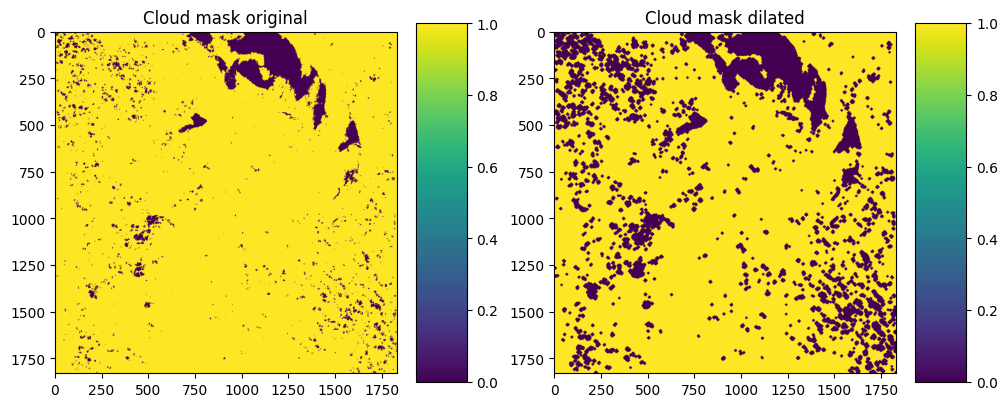

In [108]:
fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 18))

im = axes[0].imshow(cm);
fig.colorbar(im, ax=axes[0], shrink=0.2, aspect=7)
axes[0].set_title("Cloud mask original")

im = axes[1].imshow(cm_exp);
fig.colorbar(im, ax=axes[1], shrink=0.4, aspect=7)
axes[1].set_title("Cloud mask dilated")

In [52]:
# Set cloud pixels of chl-a to NaN
chla[~cm_exp] = np.nan

### Land mask

In [113]:
# Bits we want to reject
reject_bits = 1 
# # Boolean mask: True = keep pixel, False = reject
land_mask = (flags & reject_bits) == 0

Text(0.5, 1.0, 'Land Mask')

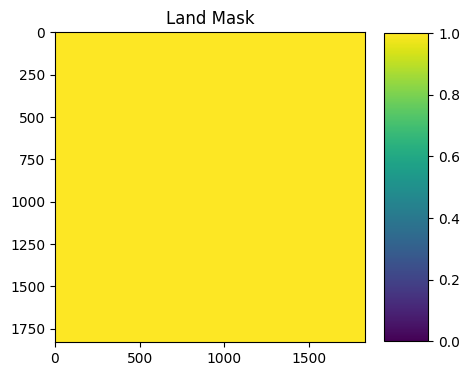

In [125]:
fig = plt.figure(figsize=(5, 5))

plt.imshow(land_mask, vmin=0, vmax=1);
plt.colorbar(shrink=0.8, aspect=7)
plt.title("Land Mask")

In [121]:
# Set land pixels of chl-a to NaN
chla[~land_mask] = np.nan

### Miscellaneous bad pixels mask

In [78]:
# Bits we want to reject
reject_bits = 4 + 8 + 16 + 32 + 64 + 128 + 512 + 2048 + 4096
reject_bits = 2048
# # Boolean mask: True = keep pixel, False = reject
bad_pixel_mask = (flags & reject_bits) == 0

# Choose the dilation structure (3×3 square here)
structure = nd.generate_binary_structure(2, 1)
bad_pixel_mask_exp = ~nd.binary_dilation(~bad_pixel_mask, structure=structure, iterations=5)

Text(0.5, 1.0, 'Bad pixel mask dilated')

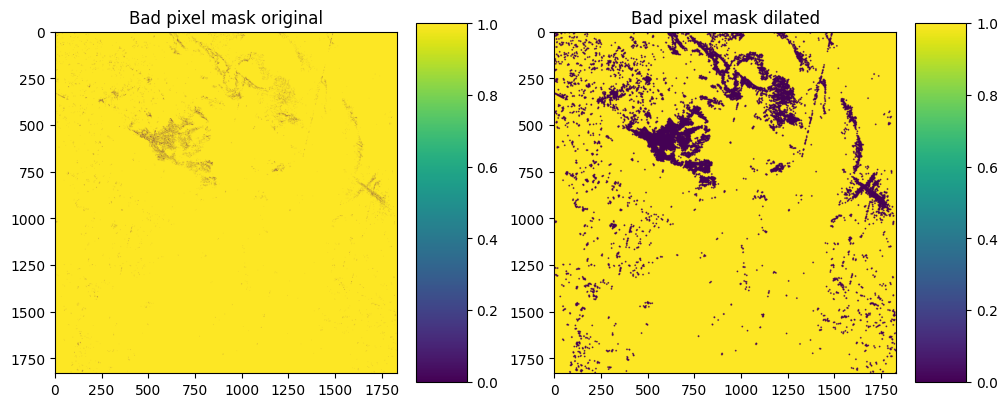

In [79]:
fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 18))

im = axes[0].imshow(bad_pixel_mask);
fig.colorbar(im, ax=axes[0], shrink=0.2, aspect=7)
axes[0].set_title("Bad pixel mask original")

im = axes[1].imshow(bad_pixel_mask_exp);
fig.colorbar(im, ax=axes[1], shrink=0.4, aspect=7)
axes[1].set_title("Bad pixel mask dilated")

In [132]:
# Set land pixels of chl-a to NaN
chla[~bad_pixel_mask_exp] = np.nan

### Plot cleaned chl-a

Text(0.5, 1.0, 'Chla')

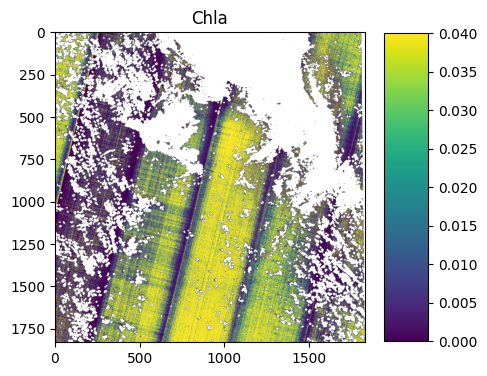

In [136]:
fig = plt.figure(figsize=(5, 5))

plt.imshow(chla**10, vmin=0, vmax=0.04);
plt.colorbar(shrink=0.8, aspect=7)
plt.title("Chla")

# Method 2 (pyresample)

In [6]:
from pyproj import CRS
from pyproj import Transformer
from pyresample import geometry, kd_tree

In [9]:
@timing_decorator
def nc2gtiff_pyresample(inp_nc: str = "/home/data/ocean-colour/S2A_MSIL1C_20241105T091151_N0511_R050_T34SGG_20241105T100127_60m.nc",
                   res: int = 60):
    
    # Set no data value
    no_data = -9999
    
    # --- Open the NetCDF file ---
    nc_path = Path(inp_nc)

    ds = xr.open_dataset(nc_path)

    # --- Example: select chlorophyll variable ---
    chla = ds["logchl"].values
    lat = ds['latitude'].values
    lon = ds['longitude'].values
    flags = ds['bitmask'].astype("int32").values

    # Convert log(mg/m^3) to mg/m^3 (optional)
    chla = 10**chla
    
    # Get Polymer Masks
    cm = get_cloud_mask(flags)
    land_mask = get_land_mask(flags)
    bad_pixel_mask = get_bad_pixel_mask(flags)

    # Apply masks on chl-a
    chla[~cm] = no_data
    chla[~land_mask] = no_data
    chla[~bad_pixel_mask] = no_data
    
    ############### Reproject #################################
    # Define swath geometry (source data)
    swath = geometry.SwathDefinition(lons=lon, lats=lat)

    # Define target area in EPSG:2100
    # Choose resolution in meters (e.g. 60 m)
    xmin, xmax = lon.min(), lon.max()
    ymin, ymax = lat.min(), lat.max()

    # Get projected extent in EPSG:2100
    crs_src = CRS.from_epsg(4326)
    crs_dst = CRS.from_epsg(2100)

    # Transform extent
    transformer = Transformer.from_crs(crs_src, crs_dst, always_xy=True)
    x_min, y_min = transformer.transform(xmin, ymin)
    x_max, y_max = transformer.transform(xmax, ymax)

    # Build target grid
    nx = int((x_max - x_min) / res)
    ny = int((y_max - y_min) / res)

    area_def = geometry.AreaDefinition(
        "target_epsg2100",
        "Reprojected Area",
        "epsg2100",
        crs_dst.to_wkt(),
        nx,
        ny,
        (x_min, y_min, x_max, y_max)
    )

    # Resample swath to grid (nearest or bilinear)
    chla_grid = kd_tree.resample_nearest(
        swath, chla, area_def,
        radius_of_influence=2*res,  # meters
        fill_value=no_data,
        nprocs=4
    )

    #################### Save to GeoTIFF #######################
    tiff_suffix = "_chla.tif"
    out_tiff = nc_path.parent / (nc_path.stem + tiff_suffix)

    transform = from_origin(x_min, y_max, res, res)
    with rasterio.open(
        out_tiff,
        "w",
        driver="GTiff",
        height=ny,
        width=nx,
        count=1,
        dtype=chla_grid.dtype,
        crs=crs_dst,
        transform=transform,
        nodata=no_data
    ) as dst:
        dst.write(chla_grid, 1)

    print(f"Saved: {out_tiff}")

In [10]:
nc2gtiff_pyresample()

Saved: /home/data/ocean-colour/S2A_MSIL1C_20241105T091151_N0511_R050_T34SGG_20241105T100127_60m_chla.tif
Function 'nc2gtiff_pyresample' executed in 2.2452 seconds


In [115]:
for ncfile in p.rglob("*.nc"):
    nc2gtiff_pyresample(inp_nc=ncfile,
                        res=60)

Saved: /home/data/ocean-colour/s2-polymer-for-cal-val/2018/S2B_MSIL1C_20181102T091129_N0500_R050_T34SFD_20230703T080411_60m_chla.tif
Function 'nc2gtiff_pyresample' executed in 2.2642 seconds
Saved: /home/data/ocean-colour/s2-polymer-for-cal-val/2018/S2B_MSIL1C_20181126T085309_N0500_R107_T35SMU_20230725T215136_60m_chla.tif
Function 'nc2gtiff_pyresample' executed in 2.1724 seconds
Saved: /home/data/ocean-colour/s2-polymer-for-cal-val/2018/S2B_MSIL1C_20181226T085359_N0500_R107_T35SNU_20230816T191338_60m_chla.tif
Function 'nc2gtiff_pyresample' executed in 2.1859 seconds
Saved: /home/data/ocean-colour/s2-polymer-for-cal-val/2018/S2A_MSIL1C_20181022T085011_N0500_R107_T35SPU_20230815T151924_60m_chla.tif
Function 'nc2gtiff_pyresample' executed in 2.2024 seconds
Saved: /home/data/ocean-colour/s2-polymer-for-cal-val/2018/S2A_MSIL1C_20181025T090031_N0500_R007_T35SLU_20230815T094421_60m_chla.tif
Function 'nc2gtiff_pyresample' executed in 2.1912 seconds
Saved: /home/data/ocean-colour/s2-polymer-for